In [47]:
import tensorflow as tf # Make sure that python interpreter is 3.9.13 Global env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU')


[]

In [2]:
ptb = pd.read_csv('C:/Users/varun/ECG_Research_Project/ECG_Model/data/ptbxl_database.csv')
ptb.head()
len(ptb)

21799

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
path = 'C:/Users/varun/ECG_Research_Project/ECG_Model/data'
sampling_rate=100

In [5]:
# load and convert annotation data
Y = pd.read_csv(path+'/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))



In [6]:


# Load raw signal data
X = load_raw_data(Y, sampling_rate, 'C:/Users/varun/ECG_Research_Project/ECG_Model/data/')

In [7]:
X.shape, Y.shape

((21799, 1000, 12), (21799, 27))

In [8]:
X[0].shape


(1000, 12)

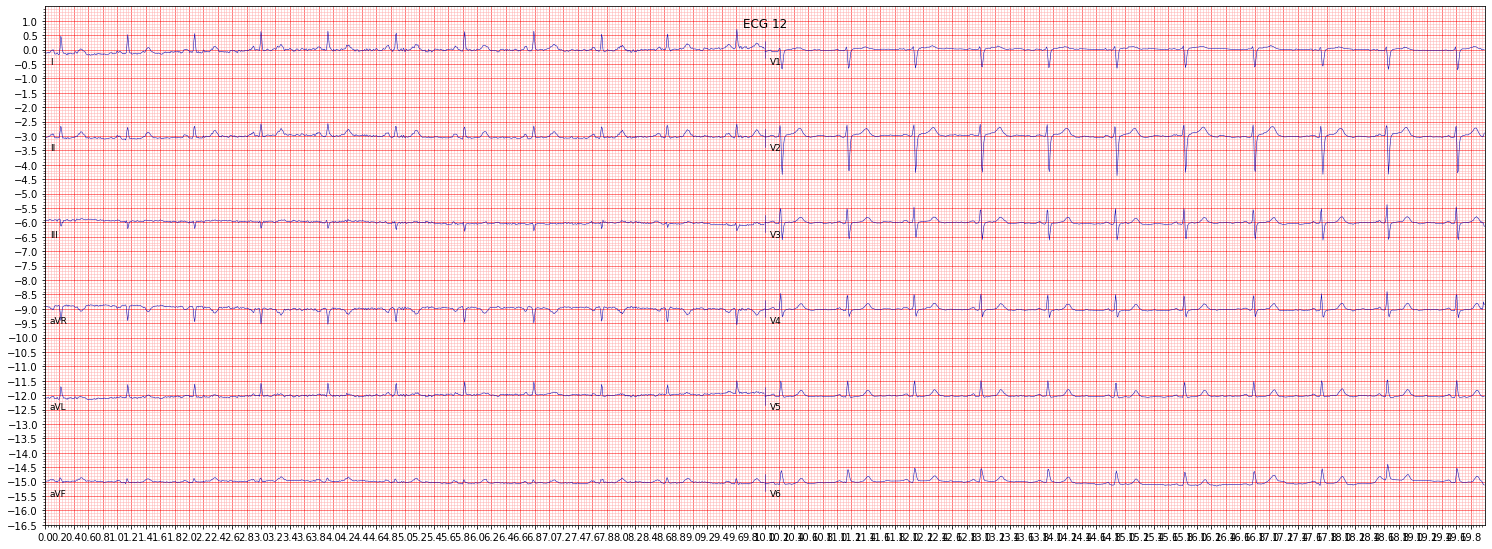

In [11]:
ecg_plot.plot(tf.transpose(X, (0,2,1))[0], sample_rate=100)

In [12]:

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


In [13]:
Y_pd = pd.DataFrame(Y)
Y_pd

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


### Visualizing the Data

Text(0.5, 1.0, 'Distribution of Sex')

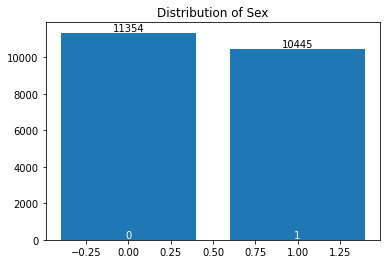

In [14]:
# Distribution of Male and Female ECGs
uniques, counts = np.unique(Y_pd.sex, return_counts=True)
plt.bar(uniques, counts)
for i in range(len(uniques)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    plt.text(i, i, str(i), ha='center', va='bottom', color = "white")
plt.title("Distribution of Sex")

Text(0.5, 1.0, 'Distribution of Diagnostic Superclasses')

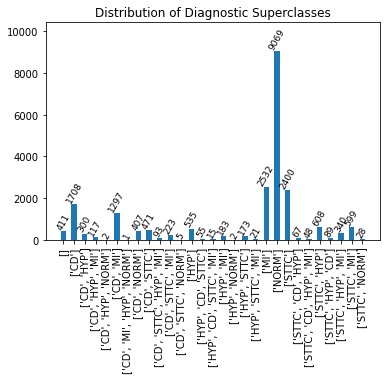

In [15]:
diag_uniques, diag_counts = np.unique(Y_pd.diagnostic_superclass, return_counts=True)
temp = [str(i) for i in diag_uniques]
plt.bar(temp, diag_counts, width = 0.5)
for i in range(len(diag_uniques)):
    plt.text(i, diag_counts[i], str(diag_counts[i]), ha='center', va='bottom', size = 9, rotation = 60)

plt.xticks(rotation = 90)
plt.ylim(0, max(diag_counts) + max(diag_counts)*0.15)
plt.title("Distribution of Diagnostic Superclasses")

### Preprocessing

In [29]:
# Normalization
# Compute mean and standard deviation along axis 1 and 2
X_mean = np.mean(X, axis=(-1), keepdims=True)
X_std = np.std(X, axis=(-1), keepdims= True)

X_mean.shape

(21799, 1000, 1)

In [30]:
# Normalize data by subtracting mean and dividing by standard deviation
X_norm = (X - X_mean) / X_std
X_norm.shape


(21799, 1000, 12)

In [32]:
X_norm[(1,2,3),:,:]

array([[[-0.59844998,  0.78021416,  0.73906   , ...,  1.33579523,
          0.21434455,  0.26578724],
        [-0.80632554,  0.79066873,  1.02552083, ...,  1.26037293,
          0.09785504,  0.16831067],
        [-1.06792948,  0.80903748,  1.49510127, ...,  1.00320648,
         -0.2135859 , -0.0970845 ],
        ...,
        [ 0.77931775,  1.18199958,  1.00609885, ..., -0.94480011,
         -0.11181568,  0.37663592],
        [-0.66311156,  0.72851435,  1.91303144, ..., -0.49597111,
         -0.11445487,  0.26342788],
        [-1.31195248,  0.13640338,  1.86252611, ..., -1.11354757,
         -0.73161811, -0.30504755]],

       [[ 0.37754233, -0.67606418, -0.04390027, ..., -1.1817953 ,
         -0.61284779, -0.40212648],
        [ 0.22181153, -0.52347522,  0.22181153, ..., -1.24746807,
         -0.71512038, -0.4808874 ],
        [-0.40078602, -0.47186138,  0.80749499, ..., -0.96938885,
         -0.68508744, -0.40078602],
        ...,
        [-0.15146323, -1.56114464, -1.36078383, ...,  

In [33]:

# Split data into train and test
test_fold =10
X_train = X_norm[(Y.strat_fold != test_fold)]
y_train = Y[Y.strat_fold != test_fold].sex

X_test = X_norm[(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].sex

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_train


((19601, 1000, 12),
 (2198, 1000, 12),
 (19601, 2),
 (2198, 2),
             0      1
 ecg_id              
 1       False   True
 2        True  False
 3       False   True
 4        True  False
 5       False   True
 ...       ...    ...
 21833   False   True
 21834    True  False
 21835   False   True
 21836   False   True
 21837    True  False
 
 [19601 rows x 2 columns])

Text(0.5, 1.0, 'Distribution of Sex')

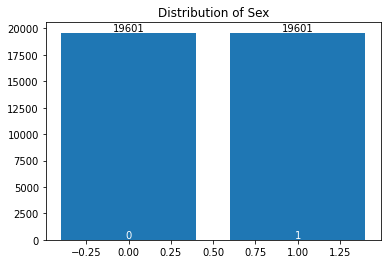

In [19]:
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)
plt.bar(uniques, counts)
for i in range(len(uniques)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    plt.text(i, i, str(i), ha='center', va='bottom', color = "white")
plt.title("Distribution of Sex")

In [ ]:
# # Reshaping for ecg_sex_ecg_sex_ecg_sex_ecg_sex_ecg_sex_ecg_sex_model_8_8_8_8_8_8
# X_train = tf.reshape(X_train, (19601, 1000, 12,1))
# X_test = tf.reshape(X_test, (2198, 1000, 12,1))

### Making the model

In [20]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 10, kernel_size = 7, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 25, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dense(2, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history = ecg_sex_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
211/613 [=========>....................] - ETA: 6s - loss: 0.6974 - accuracy: 0.5167

KeyboardInterrupt: 

In [ ]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 3, padding = "valid", activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation= 'relu'),
    tf.keras.layers.Dense(2, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0015),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history_2 = ecg_sex_model_2.fit(X_train, y_train, epochs = 8, validation_data = (X_test, y_test))

Epoch 1/8
613/613 [==============================] - 9s 13ms/step - loss: 0.6158 - accuracy: 0.6758 - val_loss: 0.5960 - val_accuracy: 0.6920
Epoch 2/8
613/613 [==============================] - 7s 12ms/step - loss: 0.4895 - accuracy: 0.7730 - val_loss: 0.4970 - val_accuracy: 0.7548
Epoch 3/8
613/613 [==============================] - 7s 12ms/step - loss: 0.4341 - accuracy: 0.8012 - val_loss: 0.5180 - val_accuracy: 0.7552
Epoch 4/8
613/613 [==============================] - 8s 12ms/step - loss: 0.3772 - accuracy: 0.8278 - val_loss: 0.5665 - val_accuracy: 0.7525
Epoch 5/8
613/613 [==============================] - 7s 12ms/step - loss: 0.3193 - accuracy: 0.8607 - val_loss: 0.5743 - val_accuracy: 0.7361
Epoch 6/8
613/613 [==============================] - 7s 12ms/step - loss: 0.2674 - accuracy: 0.8856 - val_loss: 0.6567 - val_accuracy: 0.7502
Epoch 7/8
613/613 [==============================] - 7s 12ms/step - loss: 0.2179 - accuracy: 0.9069 - val_loss: 0.7387 - val_accuracy: 0.7580
Epoch 

In [ ]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 96, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_3.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0015),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history_3 = ecg_sex_model_3.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
613/613 [==============================] - 8s 12ms/step - loss: 0.5416 - accuracy: 0.7270 - val_loss: 0.5577 - val_accuracy: 0.7320
Epoch 2/10
613/613 [==============================] - 7s 11ms/step - loss: 0.4591 - accuracy: 0.7866 - val_loss: 0.4690 - val_accuracy: 0.7753
Epoch 3/10
613/613 [==============================] - 7s 12ms/step - loss: 0.4328 - accuracy: 0.8015 - val_loss: 0.4789 - val_accuracy: 0.7812
Epoch 4/10
613/613 [==============================] - 7s 12ms/step - loss: 0.4142 - accuracy: 0.8107 - val_loss: 0.4995 - val_accuracy: 0.7648
Epoch 5/10
613/613 [==============================] - 7s 12ms/step - loss: 0.4006 - accuracy: 0.8208 - val_loss: 0.4574 - val_accuracy: 0.7843
Epoch 6/10
613/613 [==============================] - 7s 12ms/step - loss: 0.3900 - accuracy: 0.8264 - val_loss: 0.4526 - val_accuracy: 0.7934
Epoch 7/10
613/613 [==============================] - 8s 13ms/step - loss: 0.3809 - accuracy: 0.8315 - val_loss: 0.4683 - val_accuracy: 0.8030

In [ ]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_4.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)



# Fitting the model

history_4 = ecg_sex_model_4.fit(X_train, y_train, epochs = 12, validation_data = (X_test, y_test), callbacks = early_stopper)

Epoch 1/12
613/613 [==============================] - 12s 17ms/step - loss: 0.5351 - accuracy: 0.7424 - val_loss: 0.5353 - val_accuracy: 0.7648
Epoch 2/12
613/613 [==============================] - 11s 18ms/step - loss: 0.4584 - accuracy: 0.7898 - val_loss: 0.4559 - val_accuracy: 0.7875
Epoch 3/12
613/613 [==============================] - 11s 18ms/step - loss: 0.4313 - accuracy: 0.8077 - val_loss: 0.4572 - val_accuracy: 0.7975
Epoch 4/12
613/613 [==============================] - 11s 18ms/step - loss: 0.4115 - accuracy: 0.8153 - val_loss: 0.4940 - val_accuracy: 0.7766
Epoch 5/12
613/613 [==============================] - 11s 18ms/step - loss: 0.4022 - accuracy: 0.8210 - val_loss: 0.4547 - val_accuracy: 0.7925
Epoch 6/12
613/613 [==============================] - 11s 18ms/step - loss: 0.3923 - accuracy: 0.8257 - val_loss: 0.4661 - val_accuracy: 0.7925
Epoch 7/12
613/613 [==============================] - 12s 19ms/step - loss: 0.3759 - accuracy: 0.8349 - val_loss: 0.4746 - val_accuracy:

In [ ]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)
tf.keras.backend.set_image_data_format('channels_first')


# Creating the model

ecg_sex_model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu', input_shape= (1000, 12)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_5.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_5 = ecg_sex_model_5.fit(tf.transpose(X_train, (0,2,1)), y_train, epochs = 12, validation_data = (X_test, y_test), callbacks = (early_stopper))

ResourceExhaustedError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[19601,1000,12] and type double on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Transpose]

In [50]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_6 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 160, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(2, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_6.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_6 = ecg_sex_model_6.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test))

Epoch 1/25
613/613 [==============================] - 18s 27ms/step - loss: 3.0278 - accuracy: 0.7416 - val_loss: 1.1378 - val_accuracy: 0.7580
Epoch 2/25
613/613 [==============================] - 18s 29ms/step - loss: 1.0711 - accuracy: 0.7923 - val_loss: 1.1441 - val_accuracy: 0.7466
Epoch 3/25
570/613 [==========================>...] - ETA: 1s - loss: 1.0273 - accuracy: 0.7982

KeyboardInterrupt: 

In [45]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_7 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 160, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 194, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 256, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(2, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_7.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_7 = ecg_sex_model_7.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20
613/613 [==============================] - 32s 50ms/step - loss: 3.2661 - accuracy: 0.7447 - val_loss: 1.4004 - val_accuracy: 0.7525
Epoch 2/20
613/613 [==============================] - 35s 56ms/step - loss: 1.2969 - accuracy: 0.7906 - val_loss: 1.3578 - val_accuracy: 0.7598
Epoch 3/20
613/613 [==============================] - 35s 56ms/step - loss: 1.2308 - accuracy: 0.7998 - val_loss: 1.1821 - val_accuracy: 0.7812
Epoch 4/20
613/613 [==============================] - 35s 57ms/step - loss: 1.1608 - accuracy: 0.8131 - val_loss: 1.2202 - val_accuracy: 0.7498
Epoch 5/20
613/613 [==============================] - 34s 56ms/step - loss: 1.1570 - accuracy: 0.8164 - val_loss: 1.2537 - val_accuracy: 0.8025
Epoch 6/20
613/613 [==============================] - 34s 56ms/step - loss: 1.1427 - accuracy: 0.8203 - val_loss: 1.1648 - val_accuracy: 0.7898
Epoch 7/20
613/613 [==============================] - 33s 53ms/step - loss: 1.1130 - accuracy: 0.8277 - val_loss: 1.2512 - val_accuracy:

In [49]:
tf.debugging.disable_traceback_filtering
tf.config.list_physical_devices('GPU')
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_8 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=5, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(2, activation= 'softmax')
])


# Compiling the model

ecg_sex_model_8.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= .0003),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_8 = ecg_sex_model_8.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test))

Epoch 1/25
446/613 [====================>.........] - ETA: 1:17 - loss: 23.0403 - accuracy: 0.6525

KeyboardInterrupt: 

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize = (10, 10)

def make_confusion_matrix(y_true, y_pred, classes, figsize=(18,18), text_size = 15):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, tf.round(y_pred))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=10)

69/69 [==============================] - 0s 5ms/step


array([[943, 189],
       [250, 816]], dtype=int64)

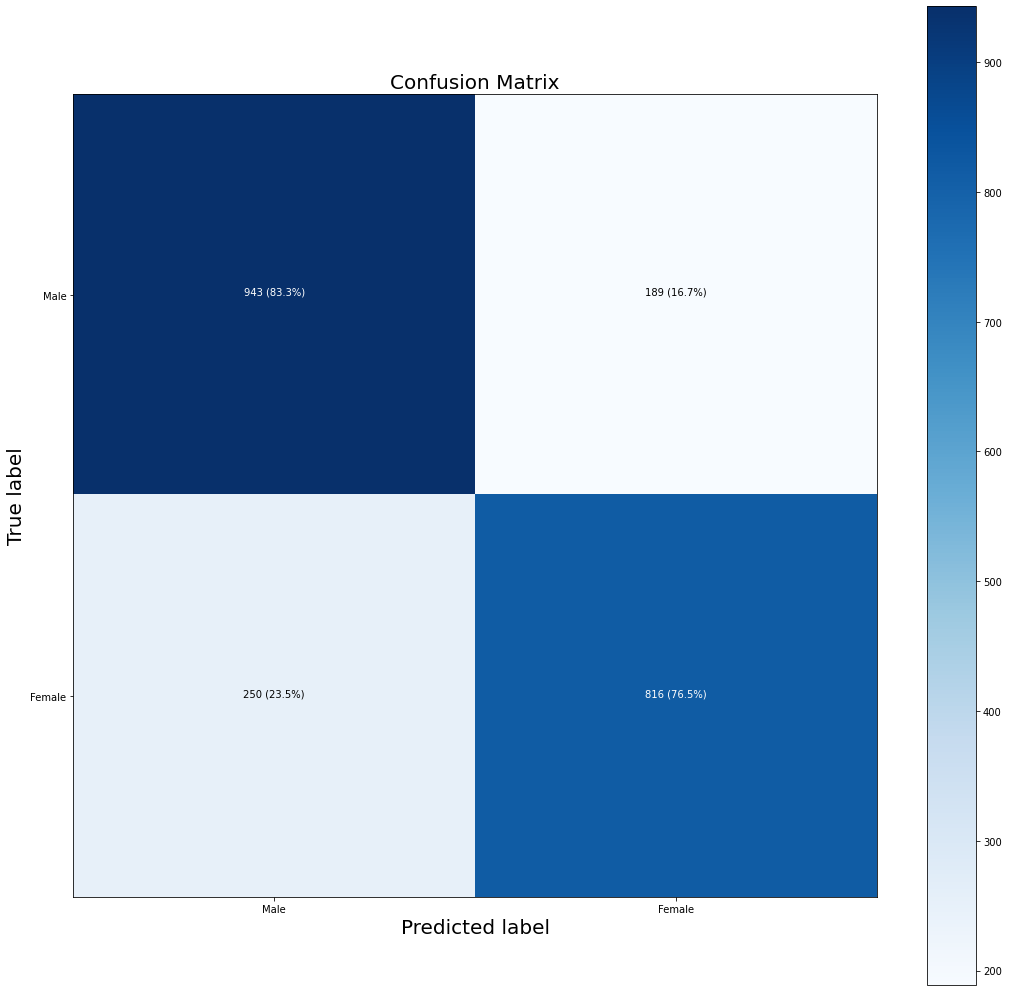

In [ ]:
y_prob = ecg_sex_model_5.predict(X_test)
y_pred = tf.argmax(y_prob, axis = 1)


class_name = ['Male', 'Female']



make_confusion_matrix(y_test.idxmax(axis = 1).to_numpy(),  y_pred.numpy(), classes = class_name)
